In [ ]:
from google.colab import drive
import torch
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from datetime import datetime
import pytz

In [ ]:
# Mount to Google Drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/Poster'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Poster


In [ ]:
# Define device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

Device: cpu


## 1. Data Processing
- **Overview**: Classes and functions for processing time series data.
- **Key Components**:
  - `TimeSeriesDataset`: Class for loading and processing time series data.
  - Data normalization and transformation techniques.

In [ ]:
# Configuration Parameters for Data Processing
CSV_FILE = 'raw_data/1_data.csv'
SEQUENCE_LENGTH = 60
BATCH_SIZE = 64
TRAIN_PERCENT = 0.8
FUTURE_STEP = 30

In [ ]:
# Data Processing Classes
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        """
        Initializes the TimeSeriesDataset.

        :Arg data: numpy.ndarray, shape [num_samples, num_features].
                    Time series data for training or validation.
        :Arg sequence_length: int, Length of input sequences.
        """
        self.data = data  # Time series data
        self.sequence_length = sequence_length

    def __len__(self):
        # Returns the total number of sequences that can be generated
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        """
        Retrieves a sequence of data given an index.

        :Arg idx: int, Index to retrieve the sequence.
        :Return seq: torch.Tensor, shape [sequence_length, num_features].
                     The input sequence of length `sequence_length`.
        """
        seq = self.data[idx:idx + self.sequence_length]  # Extract sequence
        return seq

    def get_future_y(self, idx, future_steps):
        """
        Retrieves future values from the dataset.

        :Arg idx: int, Index to start retrieving future values.
        :Arg future_steps: int, Number of future steps to retrieve.
        :Return y_seq: numpy.ndarray or None, Future values of shape [future_steps].
                       Returns None if not enough future data is available.
        """
        if idx + self.sequence_length + future_steps <= len(self.data):
            return self.data[idx + self.sequence_length:idx + self.sequence_length + future_steps, 0]  # NVIDIA prices in dimension 0
        else:
            return None  # Not enough future data

class DataProcessor:
    def __init__(self, csv_file, sequence_length, batch_size, shuffle=True, num_workers=4):
        """
        Initializes the DataProcessor.

        :Arg csv_file: str, Path to the CSV file containing the time series data.
        :Arg sequence_length: int, Length of input sequences.
        :Arg batch_size: int, Size of batches for DataLoader.
        :Arg shuffle: bool, Whether to shuffle the data.
        :Arg num_workers: int, Number of subprocesses to use for data loading.
        """
        self.csv_file = csv_file
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

        # Load and preprocess data
        self.data = self.load_and_check_csv()
        self.scaled_data = self.preprocess_data()
        self.dataset = self.create_dataset()
        self.train_loader, self.val_loader = self.create_dataloaders()

    def load_and_check_csv(self):
        """
        Loads the CSV file and checks its validity.

        :Return data: pandas.DataFrame, Loaded and checked data.
        :Raise FileNotFoundError: If the CSV file does not exist.
        :Raise ValueError: If the 'DATE' column is missing.
        """
        # Check CSV file availability
        if not os.path.isfile(self.csv_file):
            raise FileNotFoundError(f"CSV file '{self.csv_file}' not found.")

        # Read CSV file and check column names
        data = pd.read_csv(self.csv_file)

        # Check if 'DATE' column exists
        if 'DATE' not in data.columns:
            raise ValueError("CSV file must contain a 'DATE' column.")

        # Remove 'DATE' column
        data = data.drop(columns=['DATE'])

        print("CSV file check passed.")
        return data

    def preprocess_data(self):
        """
        Preprocesses the data by standardizing it and converting it to PyTorch tensor format.

        :Return scaled_data: torch.Tensor, shape [num_samples, num_features].
                             Preprocessed and scaled data.
        """
        display(self.data.head(5))  # Display first 5 rows of data
        scaler = StandardScaler()
        nvdia_return = self.data['NVDA_LR']
        self.data = self.data.drop(columns=['NVDA_LR'])

        # Standardize the data
        scaled_data = scaler.fit_transform(self.data)
        new_data = pd.DataFrame()
        new_data['NVDA_LR'] = nvdia_return
        new_data = pd.concat([new_data, pd.DataFrame(scaled_data)], axis=1)
        self.data = new_data

        print("Data scaled!")
        display(self.data.head(5))  # Display first 5 rows of scaled data
        self.data = self.data.to_numpy()  # Convert to numpy
        return torch.tensor(new_data.to_numpy(), dtype=torch.float32)  # Convert to PyTorch tensor

    def create_dataset(self):
        """
        Creates a TimeSeriesDataset instance.

        :Return dataset: TimeSeriesDataset, Dataset containing the time series data.
        """
        return TimeSeriesDataset(self.data, self.sequence_length)

    def create_dataloaders(self):
        """
        Creates DataLoader instances for training and validation datasets.

        :Return train_loader: DataLoader, DataLoader for the training dataset.
        :Return val_loader: DataLoader, DataLoader for the validation dataset.
        """
        # Split the dataset into training and validation sets
        split_index = int(TRAIN_PERCENT * len(self.dataset))
        train_dataset = torch.utils.data.Subset(self.dataset, range(split_index))
        val_dataset = torch.utils.data.Subset(self.dataset, range(split_index, len(self.dataset)))

        # Create DataLoader instances
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        return train_loader, val_loader

    def get_y_for_batch(self, batch_indices, future_steps):
        """
        Retrieves future y values for a given batch of indices.

        :Arg batch_indices: list of int, Indices for which to retrieve y values.
        :Arg future_steps: int, Number of future steps to retrieve.
        :Return future_y: torch.Tensor, shape [num_valid_samples, future_steps].
                           Stacked tensor of future y values.
        """
        future_y_list = []
        for idx in batch_indices:
            y_seq = self.dataset.get_future_y(idx, future_steps=future_steps)
            if y_seq is not None:
                # Convert numpy array to torch tensor
                future_y_list.append(torch.tensor(y_seq, dtype=torch.float32))

        # Return stacked tensor of future y values
        return torch.stack(future_y_list)  # Return stacked tensor


In [ ]:
# Initialize DataProcessor
data_processor = DataProcessor(csv_file=CSV_FILE, sequence_length=SEQUENCE_LENGTH, batch_size=BATCH_SIZE)
train_loader = data_processor.train_loader
val_loader = data_processor.val_loader

CSV file check passed.


,NVDA_LR,UMCSENT_YOY,VIXCLS,PAYEMS_YOY,NASDAQ100_LR,GOLD_LR,GDPC1_YOY,DTWEXBGS_LR,DCOILWTICO_LR,CORESTICKM159SFRBATL,ICSA_YOY,CCSA_YOY,CBBTCUSD_LR
0,-0.010039,0.100271,0.1423,0.016915,0.006121,0.018868,0.016508,0.000759,-0.007409,1.821944,-0.082873,-0.102335,0.048751
1,-0.012052,0.100271,0.1376,0.016915,-0.006995,0.010878,0.016508,0.000360,-0.015678,1.821944,-0.082873,-0.102335,0.021071
2,0.013313,0.100271,0.1355,0.016915,-0.003332,-0.000485,0.016508,0.000617,-0.005782,1.821944,-0.112948,-0.077534,0.131417
3,0.016240,0.100271,0.1292,0.016915,0.008720,-0.006808,0.016508,0.001372,0.002038,1.821944,-0.112948,-0.077534,-0.136643
4,0.013537,0.100271,0.1287,0.016915,0.002720,-0.003340,0.016508,0.001894,-0.015226,1.821944,-0.112948,-0.077534,0.050466


Data scaled!


,NVDA_LR,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.010039,0.736969,-0.511630,0.078398,0.408648,2.007720,-0.302156,0.230580,-0.264858,-0.886995,-0.192139,-0.245022,1.121219
1,-0.012052,0.736969,-0.577419,0.078398,-0.571421,1.145094,-0.302156,0.102051,-0.537946,-0.886995,-0.192139,-0.245022,0.463779
2,0.013313,0.736969,-0.606814,0.078398,-0.297686,-0.081586,-0.302156,0.184691,-0.211151,-0.886995,-0.203587,-0.232884,3.084638
3,0.016240,0.736969,-0.695000,0.078398,0.602850,-0.764307,-0.302156,0.427880,0.047103,-0.886995,-0.203587,-0.232884,-3.282149
4,0.013537,0.736969,-0.701999,0.078398,0.154494,-0.389866,-0.302156,0.596226,-0.523019,-0.886995,-0.203587,-0.232884,1.161935


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Check size
for batch in train_loader:
    print("Batch shape:", batch.shape)
    break  # Check 1 batch

Batch shape: torch.Size([64, 60, 13])


## 2. Seq2Seq Model
- **Overview**: Implementation of the Encoder-Decoder architecture using LSTM.

- **Key Components**:
  - `LSTMEncoder`: Encodes the input sequence into a context vector.
  - `LSTMDecoder`: Decodes the context vector to generate output sequences.
  - Training loop for the Seq2Seq model.

- **References**:
  - Ilya Sutskever, Oriol Vinyals and Quoc V.Le. “Sequence to Sequence Learning with Neural Networks.“ *arXiv:1409.3215* (2014).[Link](https://arxiv.org/abs/1409.3215)
  - For more detailed information on LSTM Encoder-Decoder, visit: [LSTM Encoder-Decoder Blog](https://curow.github.io/blog/LSTM-Encoder-Decoder/?fbclid=IwY2xjawFTrC5leHRuA2FlbQIxMAABHbXZ2FJhO6D41hQq1e7qhhpCC3NX5-9HYUtD2O8cDCn4UfpKstDed5XWxg_aem_TQ08QMtoXCnsjUzrdhxr0Q)


In [ ]:
# Encoder Model Class
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Linear layer for embedding input features into a higher dimensional space
        self.linear = nn.Linear(input_size, embedding_size)

        # LSTM layer for processing the embedded input sequence
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        :Arg x: torch.Tensor, shape [batch_size, seq_len, input_size].

        :Return hidden: torch.Tensor, shape [n_layers, batch_size, hidden_size].
                        The hidden state of the last time step from the LSTM.
        :Return cell: torch.Tensor, shape [n_layers, batch_size, hidden_size].
                      The cell state of the last time step from the LSTM.
        """
        # Embed the input: [batch_size, seq_len, embedding_size]
        embedded = self.dropout(F.relu(self.linear(x)))

        # RNN output processing
        # hidden: [n_layers, batch_size, hidden_size]
        # cell: [n_layers, batch_size, hidden_size]
        output, (hidden, cell) = self.rnn(embedded)

        return hidden, cell

In [ ]:
# Decoder Model Class
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, n_layers, dropout):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Linear layer for embedding input to a higher dimensional space
        self.embedding = nn.Linear(output_size, embedding_size)

        # LSTM layer for sequential processing
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # Linear layer for mapping LSTM outputs to the output size
        self.linear = nn.Linear(hidden_size, output_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        """
        :Arg x: torch.Tensor, shape [batch_size, feature_size].
        :Arg hidden: torch.Tensor, shape [n_layers, batch_size, hidden_size].
                     The hidden state from the encoder.
        :Arg cell: torch.Tensor, shape [n_layers, batch_size, hidden_size].
                    The cell state from the encoder.

        :Return prediction: torch.Tensor, shape [batch_size, output_size].
                            The predicted output from the decoder.
        :Return hidden: torch.Tensor, updated hidden state of shape [n_layers, batch_size, hidden_size].
        :Return cell: torch.Tensor, updated cell state of shape [n_layers, batch_size, hidden_size].
        """
        # Add a sequence dimension to x for LSTM input: [batch_size, 1, feature_size]
        x = x.unsqueeze(1)

        # Compute embedded representation: [batch_size, 1, embedding_size]
        embedded = self.dropout(F.relu(self.embedding(x)))

        # RNN output processing
        # output: [batch_size, 1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]
        # cell: [n_layers, batch_size, hidden_size]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # Generate prediction: [batch_size, output_size]
        prediction = self.linear(output.squeeze(1))  # output.squeeze(1) changes shape to [batch_size, hidden_size]

        return prediction, hidden, cell


In [ ]:
# Seq2Seq Model Class
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Ensure encoder and decoder have matching hidden sizes and number of layers
        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, teacher_forcing_ratio=0.5):
        """
        :Arg x: torch.Tensor, shape [batch_size, seq_len, feature_size]
        :Arg teacher_forcing_ratio: float, Probability of using teacher forcing during training.

        :Return outputs: torch.Tensor, shape [batch_size, seq_len, output_size]
        """
        batch_size = x.shape[0]
        target_len = x.shape[1]  # Use the same length for target sequence

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, target_len, self.decoder.output_size).to(self.device)

        # Encode the input sequence
        hidden, cell = self.encoder(x)

        # First input to the decoder is the last coordinate of x
        decoder_input = x[:, 0, :]  # Shape: [batch_size, feature_size]

        # Decode each time step
        for t in range(target_len):
            # Run decoder for one time step
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            # Store predictions for each time step
            outputs[:, t, :] = output

            # Decide whether to use teacher forcing
            teacher_forcing = random.random() < teacher_forcing_ratio

            # Use true label or prediction as the next input
            decoder_input = x[:, t, :] if teacher_forcing else output

        return outputs


In [ ]:
# Training and Evaluation Functions for Seq2Seq Model
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (x) in enumerate(dataloader):
        # Move data to GPU and convert to float
        x = x.to(device).float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass to get predictions (reconstruction)
        y_pred = model(x)

        # Compute loss and backpropagate
        loss = criterion(y_pred, x)
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for i, (x) in enumerate(dataloader):
            # Move data to GPU and convert to float
            x = x.to(device).float()

            # Forward pass without teacher forcing
            y_pred = model(x, teacher_forcing_ratio=0)

            # Compute loss
            loss = criterion(y_pred, x)

            # Accumulate loss
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


In [ ]:
# Initialize model parameters
NUM_EPOCHS = 250
LEARNING_RATE = 5e-5
INPUT_SIZE = 13
EMBEDDING_SIZE = 16
HIDDEN_SIZE = 32
N_LAYERS = 1
DROPOUT = 0.5
OUTPUT_SIZE = 13

In [ ]:
# Initialize Encoder & Decoder model
encoder = Encoder(input_size=INPUT_SIZE, embedding_size=EMBEDDING_SIZE,
                   hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, dropout=DROPOUT).to(device)
decoder = Decoder(output_size=OUTPUT_SIZE, embedding_size=EMBEDDING_SIZE,
                   hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, dropout=DROPOUT).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Initialize model, loss function, and optimizer
model = Seq2Seq(encoder, decoder, device).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
TRAIN_LOSSES = []
VAL_LOSSES = []

# Define the base save directory
base_save_path = 'Seq2Seq_model_state'

# Get the current timestamp for saving the model
taiwan_tz = pytz.timezone('Asia/Taipei')
current_time = datetime.now(taiwan_tz).strftime("%Y%m%d_%H%M%S")

for epoch in range(NUM_EPOCHS):
    # Train and evaluate the model
    train_loss = train(model, train_loader, optimizer, loss_function)
    val_loss = evaluate(model, val_loader, loss_function)

    # Append losses to the lists
    TRAIN_LOSSES.append(train_loss)
    VAL_LOSSES.append(val_loss)

    clear_output(wait=True)
    print(f'Epoch: {epoch+1} / {NUM_EPOCHS}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal. Loss: {val_loss:.3f}')
    print('-'*30)

    # Save the model every 25 epochs
    if (epoch + 1) % 25 == 0:
        # Create a new directory with the current timestamp inside the base path
        save_path = os.path.join(base_save_path, f'Seq2Seq_model_{current_time}')
        os.makedirs(save_path, exist_ok=True)  # Create the timestamped folder

        # Save the model in the timestamped folder
        torch.save(model.state_dict(), os.path.join(save_path, f'Seq2Seq_model_epoch_{epoch + 1}.pth'))
        print(f'Model saved at {os.path.join(save_path, f"Seq2Seq_model_epoch_{epoch + 1}.pth")}')

Epoch: 250 / 250
	Train Loss: 0.457
	Val. Loss: 0.701
------------------------------
Model saved at /content/drive/MyDrive/Seq2Seq_model_state/Seq2Seq_model_20240925_164817/Seq2Seq_model_epoch_250.pth


In [ ]:
# Plotting Procedure
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

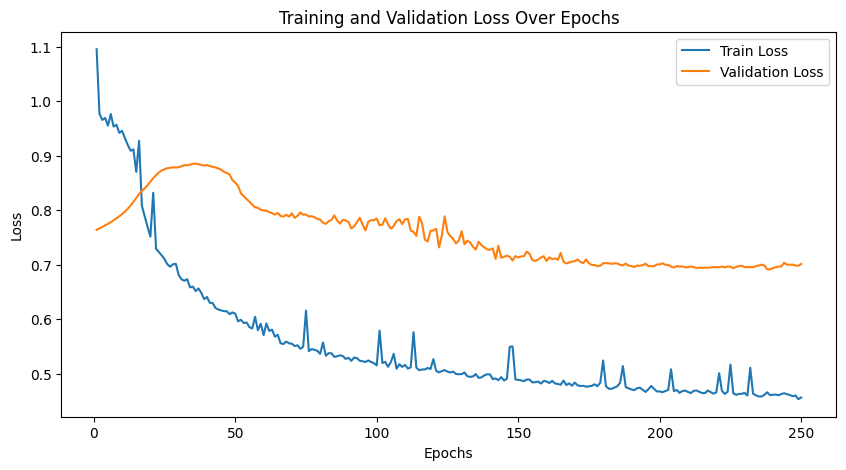

In [ ]:
plot_losses(TRAIN_LOSSES, VAL_LOSSES)

In [ ]:
# Specify the epoch number you want to load
epoch_number = 250  # For example, if you want to load the model from epoch 50
state_time = '20240925_164817'  # Specify your timestamp here, e.g., '20230925_153000'

# Construct the file name for the model
model_file_name = f'Seq2Seq_model_state/Seq2Seq_model_{state_time}/Seq2Seq_model_epoch_{epoch_number}.pth'

# Load the state of the Seq2Seq model
model.load_state_dict(torch.load(model_file_name))
print(f'Loaded model from {model_file_name}')

Loaded model from /content/drive/MyDrive/Seq2Seq_model_state/Seq2Seq_model_20240925_164817/Seq2Seq_model_epoch_250.pth


<ipython-input-26-9a4324f94f7c>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file_name))


In [ ]:
outputs=[]
inputs=[]
for input in train_loader:
  input = input.to(device)
  input = input.float()
  output = model(input)
  outputs.append(output)
  inputs.append(input)

In [ ]:
# True Label (Input data)
data = inputs[8]
first_feature = data[0, :, 0]
first_feature

tensor([ 0.0094, -0.0131, -0.0161, -0.0702,  0.0216, -0.0152, -0.0574,  0.0058,
         0.0081,  0.0143, -0.0026,  0.0164, -0.0198, -0.0247,  0.0016,  0.0269,
         0.0326, -0.0091,  0.0035, -0.0046, -0.0032,  0.0000,  0.0111, -0.0014,
         0.0012, -0.0200,  0.0000,  0.0298,  0.0637,  0.0053,  0.0084,  0.0302,
        -0.0003,  0.0078,  0.0018, -0.0049,  0.0000, -0.0130,  0.0207, -0.0012,
         0.0249,  0.0154,  0.0221, -0.0131,  0.0023,  0.0291,  0.0144, -0.0169,
         0.0126, -0.0218, -0.0295, -0.0887,  0.0541,  0.0142, -0.0506,  0.0648,
        -0.0176,  0.0200,  0.0371,  0.0208], device='cuda:0')

In [ ]:
# Seq2Seq Outputs
data = outputs[8]
first_feature = data[0, :, 0]
first_feature

tensor([ 0.0284, -0.0183, -0.0325, -0.0329, -0.0301, -0.0271, -0.0229, -0.0219,
        -0.0179, -0.0167, -0.0167, -0.0162, -0.0151, -0.0149, -0.0183, -0.0171,
        -0.0130, -0.0130, -0.0135, -0.0140, -0.0123, -0.0115, -0.0079, -0.0042,
        -0.0055, -0.0055, -0.0083, -0.0024, -0.0068, -0.0032, -0.0028, -0.0021,
        -0.0025, -0.0006,  0.0006, -0.0010,  0.0023,  0.0040,  0.0055,  0.0070,
         0.0086,  0.0083,  0.0112,  0.0131,  0.0175,  0.0178,  0.0174,  0.0225,
         0.0252,  0.0220,  0.0285,  0.0311,  0.0339,  0.0353,  0.0380,  0.0429,
         0.0401,  0.0439,  0.0461,  0.0481], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
data.shape

torch.Size([64, 60, 13])

## 3. GAN Model
- **Overview**: Conditional GAN architecture for generating time series data.
- **Key Components**:
  - **Data Processing**:
    - Encoder model processes historical stock prices and economic indicators to produce `cond_data` (conditional input for the generator).
  - `DNNGenerator`: Deep Neural Network generator for generating data from noise and conditional input.
  - `ProjectionDiscriminator`: LSTM-based discriminator for evaluating the generated data.
  - Training loop for GAN with loss calculations and model saving.
- **References**:
    - Arjovsky, Martin, Soumith Chintala, and Léon Bottou. “Wasserstein GAN.” *arXiv:1701.07875* (2017). [Link](https://arxiv.org/abs/1701.07875)
    - Takeru Miyato and Masanori Koyama. “cGANs with Projection Discriminator.” *arXiv:1802.05637* (2018). [Link](https://arxiv.org/abs/1802


In [ ]:
# Data Processing for training GANs

cond_datas = []
real_datas = []

# Iterate through the train_loader batches
for batch in train_loader:
    print(f"Train_data shape: {batch.shape}")  # Example: Cond_data shape: [128, 60, 13]

    # Move the inputs to the appropriate device and ensure they are in float32 format
    inputs = batch.to(device)
    inputs = inputs.float()

    # Pass through the encoder model to get conditional data
    cond_data, _ = model.encoder(inputs)
    print(f"Cond_data shape: {cond_data.shape}")  # Example: Cond_data shape: [128, latent_dim]

    # Detach the conditional data from the computation graph and remove extra dimensions
    cond_data = cond_data.squeeze().detach()

    # Extract the corresponding real data (e.g., Day 61-90 NVIDIA log return)
    batch_indices = range(batch.size(0))
    real_data = data_processor.get_y_for_batch(batch_indices, FUTURE_STEP)
    print(f"Real_data shape: {real_data.shape}")  # Example: Real_data shape: [128, 30]

    # Append processed data to the lists
    cond_datas.append(cond_data.squeeze(0))
    real_datas.append(real_data)

# Concatenate all the conditional data and real data
cond_datas = torch.cat(cond_datas, dim=0)
real_datas = torch.cat(real_datas, dim=0)

# Create a TensorDataset from the concatenated data
GANs_dataset = torch.utils.data.TensorDataset(real_datas, cond_datas)

# Create a DataLoader for the GAN model training
GANs_data_loader = DataLoader(GANs_dataset, batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.Size([64, 60, 13])
Cond_data shape: torch.Size([1, 64, 32])
Real_data shape: torch.Size([64, 30])
Train_data shape: torch.

In [ ]:
# Check GANs data shape
for real_data_batch, cond_data_batch in GANs_data_loader:
    # Process each batch here
    print(f"Condition data batch shape: {cond_data_batch.shape}")
    print(f"Real data batch shape: {real_data_batch.shape}")
    break # Stop after first batch

Condition data batch shape: torch.Size([64, 32])
Real data batch shape: torch.Size([64, 30])


In [ ]:
real_data_batch

tensor([[-0.0134,  0.0062,  0.0006,  ...,  0.0108, -0.0206,  0.0014],
        [ 0.0062,  0.0006,  0.0405,  ..., -0.0206,  0.0014,  0.0122],
        [ 0.0006,  0.0405, -0.0065,  ...,  0.0014,  0.0122, -0.0246],
        ...,
        [-0.0109, -0.0117, -0.0156,  ...,  0.0034,  0.0167, -0.0326],
        [-0.0117, -0.0156,  0.0103,  ...,  0.0167, -0.0326,  0.0108],
        [-0.0156,  0.0103, -0.0135,  ..., -0.0326,  0.0108, -0.0023]])

In [ ]:
cond_data_batch

tensor([[-1.6381e-01,  7.3727e-01,  8.3970e-01,  ...,  7.3610e-01,
         -6.5914e-01, -5.4701e-01],
        [ 4.3311e-01, -1.9993e-04,  1.9187e-03,  ..., -7.8429e-02,
         -4.5693e-01, -9.2375e-02],
        [ 3.8893e-01,  1.4757e-01,  4.0123e-02,  ..., -1.5982e-01,
         -4.8920e-01, -2.5448e-01],
        ...,
        [ 4.0947e-01,  2.9294e-01,  1.8145e-01,  ..., -5.1003e-01,
         -6.5138e-01,  3.1354e-02],
        [ 4.0202e-01,  2.1688e-01,  8.7214e-02,  ..., -3.7700e-01,
         -5.7217e-01, -7.7908e-02],
        [ 3.6292e-01,  1.7197e-01,  1.2919e-01,  ..., -2.8050e-01,
         -5.1820e-01, -2.8276e-01]], device='cuda:0')

In [ ]:
class CNNGenerator(nn.Module):
    def __init__(self, input_dim, cond_dim, dnn_hidden_dim, output_dim):
        super(CNNGenerator, self).__init__()
        self.generator_cnn = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm1d(num_features = 6),
            nn.ReLU(),
            nn.Conv1d(in_channels = 6, out_channels = 12, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm1d(num_features = 12),
            nn.ReLU(),
            nn.Conv1d(in_channels = 12, out_channels = 12, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm1d(num_features = 12),
            nn.ReLU(),
            nn.Flatten()
        )
        self.linear1 = nn.Linear(in_features = 12 * (input_dim + cond_dim), out_features = 128)
        self.linear2 = nn.Linear(in_features = 128, out_features = output_dim)

    def forward(self, noise, cond):
        """
        :Arg noise: torch.Tensor, shape [batch_size, input_dim].
        :Arg cond: torch.Tensor, shape [batch_size, cond_dim].

        :Return: torch.Tensor, shape [batch_size, output_dim].
        The generated data from the generator.
        """
        # Concatenate noise with conditional input
        x = torch.cat((noise, cond), dim=1)  # Shape: (batch_size, input_dim + cond_dim)
        x = x.unsqueeze(1)

        # Pass through the generator
        generated_data = self.generator_cnn(x)
        generated_data = nn.functional.relu(self.linear1(generated_data))
        generated_data = self.linear2(generated_data)

        # generated_data = self.generator(x)  # Shape: (batch_size, output_dim)
        return generated_data

In [ ]:
# LSTM-based projection discriminator class
class ProjectionDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, cond_dim):
        super(ProjectionDiscriminator, self).__init__()
        # Define LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        # Projection layer for conditional data
        # self.cond_projection = nn.Linear(cond_dim, hidden_dim)

        self.fc = nn.Linear(input_dim + cond_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, time_series, cond):
        """
        :Arg time_series: torch.Tensor, shape [batch_size, input_dim].
        :Arg cond: torch.Tensor, shape [batch_size, cond_dim].

        :Return: torch.Tensor, shape [batch_size, 1].
        The final score indicating realness and projection.
        """
        # Add sequence dimension: (batch_size, 1, input_dim)
        time_series_unsqueeze = time_series.unsqueeze(1)
        lstm_out, _ = self.lstm(time_series_unsqueeze)  # LSTM output: (batch_size, seq_length, hidden_dim)
        hidden_rep = lstm_out[:, -1, :]  # Get the last hidden state: (batch_size, hidden_dim)

        # Compute realness score based on hidden representation
        realness_score = self.output_layer(hidden_rep)  # Shape: (batch_size, 1)

        # Concatenate time_series and cond along the last dimension
        combined_input = torch.cat((time_series, cond), dim=1)  # (batch_size x (input_dim + cond_dim))

        # Pass through the fully connected layer
        out = self.fc(combined_input)  # (batch_size x hidden_dim)
        out = F.leaky_relu(out)
        projection_score = self.output_layer(out)  # (batch_size x 1)

        # Total score: realness + projection score
        final_score = realness_score + projection_score  # Shape: (batch_size, 1)

        return final_score

In [ ]:
# Generator loss (Adversarial Loss)
def generator_loss(critic, fake_data, cond_data):
    """
    :Arg critic: ProjectionDiscriminator, the projection discriminator.
    :Arg fake_data: torch.Tensor, generated data from the generator.
    :Arg cond_data: torch.Tensor, conditional input.

    :Return: torch.Tensor.
    Negative mean score of the fake data, representing generator loss.
    """
    fake_score = critic(fake_data, cond_data)  # Score for generated data
    return -fake_score.mean()  # Adversarial Loss (maximize critic's score)


In [ ]:
# Critic loss (Projection Discriminator)
def critic_loss(critic, real_data, fake_data, cond_data):
    """
    :Arg critic: ProjectionDiscriminator, the projection discriminator.
    :Arg real_data: torch.Tensor, real data samples.
    :Arg fake_data: torch.Tensor, generated data from the generator.
    :Arg cond_data: torch.Tensor, conditional input.

    :Return: torch.Tensor, WGAN Critic loss.
    """
    real_score = critic(real_data, cond_data)  # Score for real data
    fake_score = critic(fake_data, cond_data)  # Score for generated data
    return -(real_score.mean() - fake_score.mean())  # WGAN Critic loss


In [ ]:
# Training a Conditional GAN with Projection Discriminator
def train_cgan_projection(generator, critic, gen_opt, critic_opt, data_loader, num_epochs, device, n_critic=1, clip_value=0.01):
    """
    Train the Conditional GAN with a projection discriminator.

    :Arg generator: DNNGenerator, the generator model.
    :Arg critic: ProjectionDiscriminator, the projection discriminator model.
    :Arg gen_opt: Optimizer for the generator.
    :Arg critic_opt: Optimizer for the critic.
    :Arg data_loader: DataLoader, provides the real and conditional data.
    :Arg num_epochs: int, number of training epochs.
    :Arg device: torch.device, device to run the model on (CPU or GPU).
    :Arg n_critic: int, number of critic updates per generator update.
    :Arg clip_value: float, clipping value for the critic weights.

    :Return: Tuple of lists containing average generator and critic losses per epoch.
    """
    generator_loss_list = []  # List to store generator losses
    critic_loss_list = []  # List to store critic losses

    # Get current time for saving models
    taiwan_tz = pytz.timezone('Asia/Taipei')
    current_time = datetime.now(taiwan_tz).strftime("%Y%m%d_%H%M%S")

    for epoch in range(num_epochs):
        c_loss = 0  # Initialize critic loss for this epoch
        g_loss = 0  # Initialize generator loss for this epoch

        for real_data, cond_data in data_loader:
            real_data, cond_data = real_data.to(device), cond_data.to(device)  # Move data to device

            # ---- Critic Training ---- #
            for _ in range(n_critic):
                # Generate noise and fake data
                noise = torch.randn(cond_data.size(0), cond_data.size(1)).to(device)
                fake_data = generator(noise, cond_data).detach()  # Detach for critic update

                # Calculate critic loss (real vs fake)
                loss_critic = critic_loss(critic, real_data, fake_data, cond_data)
                c_loss += loss_critic.item()  # Accumulate critic loss

                # Optimize the critic
                critic_opt.zero_grad()  # Zero gradients for the critic
                loss_critic.backward()  # Backpropagation
                critic_opt.step()  # Update critic parameters

                # Weight clipping (WGAN requirement)
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # ---- Generator Training ---- #
            noise = torch.randn(cond_data.size(0), cond_data.size(1)).to(device)  # Generate new noise
            fake_data = generator(noise, cond_data)  # Generate fresh data

            # Calculate generator loss based on critic's score
            gen_score = critic(fake_data, cond_data)
            loss_gen = -gen_score.mean()  # Maximize critic's score (WGAN-GP style loss)
            g_loss += loss_gen.item()  # Accumulate generator loss

            # Optimize the generator
            gen_opt.zero_grad()  # Zero gradients for the generator
            loss_gen.backward()  # Backpropagation
            gen_opt.step()  # Update generator parameters

        # Save average losses for monitoring
        generator_loss_list.append(g_loss / len(data_loader))
        critic_loss_list.append(c_loss / (len(data_loader) * n_critic))

        # Save the model every 25 epochs after the first 100 epochs
        if (epoch + 1) >= 100 and (epoch + 1) % 25 == 0:
            # Define the base save directory
            base_save_path = 'GAN_model_state'

            # Create a new directory with the current timestamp inside the base path
            save_path = os.path.join(base_save_path, f'GAN_model_{current_time}')
            os.makedirs(save_path, exist_ok=True)  # Create the timestamped folder

            # Save each model in the timestamped folder
            torch.save(generator.state_dict(), os.path.join(save_path, f'generator_epoch_{epoch+1}.pth'))
            torch.save(critic.state_dict(), os.path.join(save_path, f'critic_epoch_{epoch+1}.pth'))

        # Optional: Visualize loss progression
        clear_output(wait=True)
        fig, ax1 = plt.subplots(figsize=(6.4, 4))

        # Plot Generator Loss on the left y-axis
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Generator Loss', color='black')
        ax1.plot(generator_loss_list, label='Generator Loss', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.spines['left'].set_color('black')

        # Plot Critic Loss on the right y-axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Critic Loss', color='black')
        ax2.plot(critic_loss_list, label='Critic Loss', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.spines['right'].set_color('black')

        # Add title and legend
        plt.title('Loss Progression of Generator and Critic')
        fig.legend(loc='upper left', bbox_to_anchor=(0.10, 0.95), bbox_transform=ax1.transAxes)

        fig.tight_layout()  # Adjust layout
        plt.show()

    return generator_loss_list, critic_loss_list


In [ ]:
# Set hyperparameters
G_INPUT_DIM = 32
G_COND_DIM = 32
C_INPUT_DIM = 30
C_COND_DIM = G_COND_DIM
HIDDEN_DIM = 128
OUTPUT_DIM = 30  # Feature 30-day log return
LATENT_DIM = 32
G_lr = 5e-5
C_lr = 5e-5
GANs_NUM_EPOCHS = 2000

In [ ]:
# Initialize models
generator = CNNGenerator(input_dim=G_INPUT_DIM, cond_dim=G_COND_DIM, dnn_hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM).to(device)
critic = ProjectionDiscriminator(C_INPUT_DIM, HIDDEN_DIM, C_COND_DIM).to(device)

# Optimizers
gen_opt = optim.RMSprop(generator.parameters(), lr=G_lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
critic_opt = optim.RMSprop(critic.parameters(), lr=C_lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

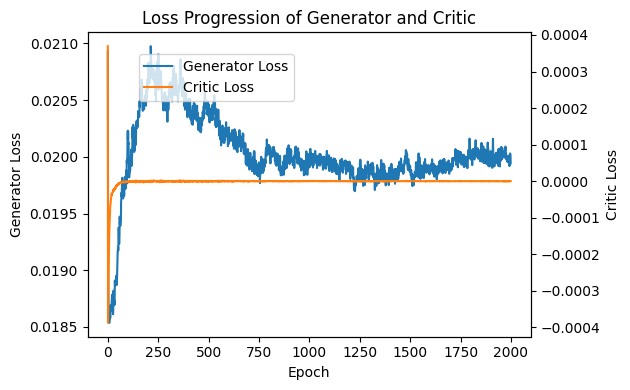

In [ ]:
# Training
generator_loss_list, critic_loss_list = train_cgan_projection(generator, critic, gen_opt, critic_opt, GANs_data_loader, GANs_NUM_EPOCHS, device)

In [ ]:
def find_best_epoch(generator_loss_list, start_epoch=1200, end_epoch=1300, step=25):
    """
    Find the epoch with the lowest generator loss within a given range.

    :Arg generator_loss_list: List of generator losses per epoch.
    :Arg start_epoch: int, the starting epoch to search (default: 1200).
    :Arg end_epoch: int, the ending epoch to search (default: 1300).
    :Arg step: int, the step size for the epoch (default: 25).

    :Return: Tuple of the lowest loss and the corresponding epoch.
    """
    # Calculate the indices that correspond to the given epoch range
    start_index = (start_epoch - 1) // step
    end_index = (end_epoch - 1) // step

    # Slice the loss list for the desired range
    sliced_loss_list = generator_loss_list[start_index:end_index+1]

    # Find the minimum loss and the corresponding epoch
    min_loss = min(sliced_loss_list)
    min_loss_index = sliced_loss_list.index(min_loss)

    # Convert the index back to the corresponding epoch number
    best_epoch = start_epoch + min_loss_index * step

    return min_loss, best_epoch


In [ ]:
best_loss, best_epoch = find_best_epoch(generator_loss_list, start_epoch=1200, end_epoch=1300)
print(f"Best generator model found at epoch {best_epoch} with loss {best_loss}")


Best generator model found at epoch 1200 with loss 0.018993029903088297


## 4. Generated Data Visualization

- **Overview**: Visualization of the generated time series data to assess the quality and patterns of the generated outputs.
- **Key Components**:
  - Line plots to compare selected generated data against real data.
  - Visual assessments of trends, distributions, and similarities between real and generated data.


In [ ]:
# Specify the epoch number you want to load
epoch_number = 1200  # For example, if you want to load the model from epoch 50
state_time = '20240925_185152'  # Specify your timestamp here, e.g., '20230925_153000'

# Construct the file name for the generator model
generator_file_name = f'GAN_model_state/GAN_model_{state_time}/generator_epoch_{epoch_number}.pth'

# Load the state of the generator model
generator.load_state_dict(torch.load(generator_file_name))
print(f'Loaded generator model from {generator_file_name}')


Loaded generator model from /content/drive/MyDrive/GAN_model_state/GAN_model_20240925_185152/generator_epoch_1200.pth


<ipython-input-122-889e264eee2b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_file_name))


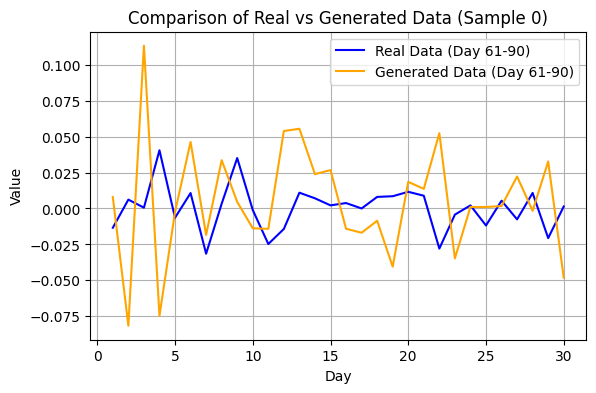

In [ ]:
# Generated Data Visualization: Comparison with Real Data (30-day segmented real data)
# Function to visualize real vs generated data
def plot_real_vs_generated(real_data, generated_data, index=0):
    """
    Plot a line graph comparing real data with generated data for a selected index.

    :param real_data: torch.Tensor, shape [batch_size, future_step], real stock prices/log returns
    :param generated_data: torch.Tensor, shape [batch_size, future_step], generated stock prices/log returns
    :param index: int, the index of the data sample to visualize
    """
    # Select real and generated data for the given index
    real = real_data[index].cpu().detach().numpy()  # Real data for future steps (61-90)
    generated = generated_data[index].cpu().detach().numpy()  # Generated future predictions

    # Plot the real and generated data for future steps (61-90 days)
    plt.figure(figsize=(6.4, 4))
    plt.plot(range(1, 31), real, label="Real Data (Day 61-90)", color='blue', linestyle='-')
    plt.plot(range(1, 31), generated, label="Generated Data (Day 61-90)", color='orange', linestyle='-')
    plt.title(f"Comparison of Real vs Generated Data (Sample {index})")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


# Select a batch of real and conditional data from the GANs_data_loader
for real_batch, cond_batch in GANs_data_loader:
    real_batch = real_batch.to(device)  # Real data (61-90 days, 30-day segments)
    cond_batch = cond_batch.to(device)  # Conditional data (1-60 days)

    # Generate future predictions for 61-90 days using the loaded generator model
    noise = torch.randn(cond_batch.size(0), cond_batch.size(1)).to(device)
    generated_batch = generator(noise, cond_batch)  # Shape [batch_size, 30], predicting days 61-90

    # Plot comparison for the first sample (index 0)
    plot_real_vs_generated(real_batch, generated_batch, index=0)

    # You can add more comparisons if needed, e.g., for multiple indices
    break  # Only process one batch for visualization